In [2]:
import pandas as pd
import numpy as np
import random

In [3]:
from google.colab import drive
drive.mount("/content/drive/")

Mounted at /content/drive/


In [4]:
path1 = "/content/drive/Shareddrives/DatosSIMA/meteo_flags.xlsx"
path2 = "/content/drive/Shareddrives/DatosSIMA/pollu_flags.xlsx"

In [5]:
import xlrd

from pandas.core import apply

# A esta función le das la ruta del archivo xlsx de varias hojas y te regresa un 
# diccionario con el nombre de cada hoja como llave la cual contiene el dataframe 
# de dicha hoja.

def read_all_sheets(path):  
  df_dict = {}
  for i in xlrd.open_workbook(path, on_demand=True).sheet_names(): 
    globals()[f'{i}'] = pd.read_excel(path, sheet_name=i)
    df_dict[i] = globals()[f'{i}']
  return df_dict

In [6]:
# A esta función le das un diccionario que guarde dataframes en cada uno de sus elementos, en este caso 
# para las banderas te lee cada una de las banderas existentes de todas las hojas y te regresa una lista 
# con todas las banderas existentes

def flags(df_dict):
  flags = set()
  for key in df_dict.keys():
    df = df_dict[key][key+'f'].value_counts().rename_axis('unique_values').reset_index(name='counts')
    flags = flags | set(df['unique_values'])
    flags_list = list(flags)
  return flags_list 

# A esta función le das un diccionario que guarde dataframes y la lista de banderas existentes
# Para que así te junte en un dataframe todas las banderas y te diga cuantas tiene cada variable

def merge_flags(df_dict, flags_list):
  df = pd.DataFrame({'Flags':flags_list})
  for key in df_dict.keys():  
    aux_df = df_dict[key][key+'f'].value_counts().rename_axis('Flags').reset_index(name=key)
    df = df.merge(aux_df,how='left', left_on='Flags', right_on='Flags').fillna(0)
  df[list(df_dict.keys())] = df[list(df_dict.keys())].astype(int)
  return df

#A esta función le das el diccionario que guarde dataframes y te regresa todos los dataframes existentes
# en un sólo dataframe tomando siempre el de mayor longitud al que se le va a agregar el otro para que 
# no se eliminen fechas y los que no tienen registros en dichas fechas se rellenen con NaN 

def merge_data_no_flags(df_dict, datetime_column ):
  df = pd.DataFrame({datetime_column: []})
  for key in df_dict.keys():
    min = df.shape[0]
    if df_dict[key].shape[0] > min:
      df = df_dict[key].drop(key+'f', axis=1).merge(df,how='left', left_on=datetime_column, right_on=datetime_column)
    else: 
      df = df.merge(df_dict[key].drop(key+'f', axis=1),how='left', left_on=datetime_column, right_on=datetime_column)
  return df

def merge_data_with_flags(df_dict, datetime_column):
  df = pd.DataFrame({datetime_column: []})
  for key in df_dict.keys():
    min = df.shape[0]
    if df_dict[key].shape[0] > min:
      df = df_dict[key].merge(df,how='left', left_on=datetime_column, right_on=datetime_column)
    else: 
      df = df.merge(df_dict[key],how='left', left_on=datetime_column, right_on=datetime_column)
  df = df.rename(columns={datetime_column:"date"})
  return df

# Esta función te mezcla dos diccionarios.

def merge_two_dicts(x, y):
    z = x.copy() 
    z.update(y)  
    return z

# A esta función le das un Dataframe y te regresa los estadísticos principales

def df_stats(data_stats):
  data_stats=data_stats.select_dtypes(include=np.number)  
  stats = pd.concat([
            data_stats.describe().T,
            data_stats.mode(numeric_only=True).iloc[0].rename("Mode"),
            data_stats.var( numeric_only=True).rename("Var"),
            data_stats.sem(numeric_only=True).rename('SE Mean'),
            data_stats.isnull().sum().rename('N*')
            ],
            axis = 1)
  stats = stats.rename(columns={"count": "N",
                            "std": "StdDev",
                            "25%":"Q1",
                            "75%":"Q3",
                            "50%":"Median",
                            "min":"Minimum",
                            "max":"Maximum",
                            "mean":"Mean"
                            })
  column_names = ["N",
                  "N*",
                  "Mean", 
                  "SE Mean", 
                  "StdDev", 
                  "Var", 
                  "Minimum", 
                  "Maximum", 
                  "Q1", 
                  "Median", 
                  "Q3", 
                  "Mode"]
  return stats.reindex(columns=column_names)


#A esta función le das un dataframe y te regresa un diccionario con varios dataframes divididos 
# entre los años que existen en las fechas
def data_by_years(df, datetime_column, data_type):
  df[datetime_column] = pd.to_datetime(df[datetime_column], format='%Y-%m-%d %H:%M:%s')
  min_year = min(df[datetime_column]).year
  max_year = max(df[datetime_column]).year
  years_dict = {}
  for i in range(min_year, max_year+1):
      
    x = df.loc[(df[datetime_column] >= str(i)+'-01-01')
                  & (df[datetime_column] < str(i+1)+'-01-01')]
    years_dict[data_type+'_'+str(i)] = x

  return years_dict

#A esta función le das un dataframe de solamente 1 año y te regresa un diccionario con varios dataframes divididos 
# entre los meses que existen en las fechas

def data_by_months(df, datetime_column): 
  df[datetime_column] = pd.to_datetime(df[datetime_column], format='%Y-%m-%d %H:%M:%s') 
  months = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']
  year = min(df[datetime_column]).year
  months_dict = {}
  for i in months:
    if i != '12':
      month = df.loc[(df[datetime_column] >= str(year)+'-'+i+'-01')
                    & (df[datetime_column] < str(year)+'-'+i+'-01')]
    else:
      month = df.loc[(df[datetime_column] >= str(year)+'-'+i+'-01')
                    & (df[datetime_column] < str(year+1)+'-01-01')]
    months_dict['data_'+str(year)+'_'+i] = month
  return months_dict 

def apply_flags(df, data_type):
  if data_type == 'meteo':
    for i in df.loc[df['SRf'] =='l'].index:
      df.SR[i] = round(random.uniform(0.01, 0.09),3)
      df.SRf[i] = 0
    for i in df.loc[df['WDf'] =='D'].index:
      df.WDf[i] = df.WDf[i]   
    for key in list(df.select_dtypes(include='number').columns):
      df[key+'f'] = df[key+'f'].fillna(0)
      for i in df.loc[df[key+'f'] != 0].index:
        df[key][i] = np.nan 
      df = df.drop(key+'f', axis=1)
  if data_type == 'pollu':
    for key in list(df.select_dtypes(include='number').columns):
      df[key+'f'] = df[key+'f'].fillna(0)
      for i in df.loc[df[key+'f'] != 0].index:
        df[key][i] = np.nan
      df = df.drop(key+'f', axis=1)
  return df




def merge_dataframes(df1, df2, column_to_merge):
  if df2.shape[0] > df1.shape[0]:
    df = df2.merge(df1,how='left', left_on=column_to_merge, right_on=column_to_merge)
  else: 
    df = df1.merge(df2,how='left', left_on=column_to_merge, right_on=column_to_merge)
  return df


 # A esta función le das una ruta en la quieras guardar un dataframe, el dataframe que quieras guardar y el nombre
 # con el que lo quieras guardar y te lo guarda en DRIVE 
  
def save_to_Drive(path,df,name): 
  route = path+name+'.csv'
  with open(route, 'w', encoding = 'utf-8-sig') as f:
    df.to_csv(f, index=False)

def data_description(df): 
  description = pd.concat(
    [df.count().rename('Count'),
    df.dtypes.rename("Data Type"),
    df.apply(pd.Series.nunique).rename("# uniq"),
    df.apply(pd.Series.unique).rename("Valores")
    ],
    axis = 1
  )

  description = description.reset_index()
  description = description.rename(columns={"index":"Abreviatura"})

  path = "/content/drive/Shareddrives/DatosSIMA/variables_meanings.xlsx"

  meaning = pd.read_excel(path)

  description = merge_dataframes(meaning,description, 'Abreviatura' )
  return description

In [7]:
dict_met=read_all_sheets(path1)
dict_pollu=read_all_sheets(path2)

In [8]:
dict_met.keys()

dict_keys(['TOUT', 'RH', 'SR', 'RAINF', 'PRS', 'WS', 'WD'])

In [9]:
dict_pollu.keys()

dict_keys(['PM10', 'PM2_5', 'SO2', 'O3', 'CO', 'NO', 'NO2', 'NOx'])

In [10]:
dict_all=merge_two_dicts(dict_met, dict_pollu)
df_new=merge_data_with_flags(dict_all, 'Fecha')

In [11]:
df_new

,date,PM2_5,PM2_5f,PM10,PM10f,RAINF,RAINFf,SR,SRf,RH,...,O3,O3f,CO,COf,NO,NOf,NO2,NO2f,NOx,NOxf
0,2017-01-01 00:00:00,NaN,a,143.0,NaN,0.0,NaN,0.004,NaN,64.0,...,6.0,NaN,2.47,NaN,16.0,NaN,15.1,NaN,31.1,NaN
1,2017-01-01 01:00:00,NaN,a,183.0,NaN,0.0,NaN,0.004,NaN,66.0,...,5.0,NaN,2.18,NaN,8.9,NaN,11.7,NaN,20.6,NaN
2,2017-01-01 02:00:00,NaN,a,142.0,NaN,0.0,NaN,0.004,NaN,56.0,...,6.0,NaN,1.77,NaN,2.0,NaN,8.6,NaN,10.5,NaN
3,2017-01-01 03:00:00,NaN,a,101.0,NaN,0.0,NaN,0.004,NaN,52.0,...,7.0,NaN,1.93,NaN,7.2,NaN,10.0,NaN,17.2,NaN
4,2017-01-01 04:00:00,NaN,a,85.0,NaN,0.0,NaN,0.004,NaN,54.0,...,7.0,NaN,1.70,NaN,2.1,NaN,8.6,NaN,10.7,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39389,2021-06-30 19:00:00,4.33,NaN,24.0,NaN,0.0,NaN,0.040,NaN,79.0,...,19.0,NaN,1.89,NaN,1.8,NaN,4.3,NaN,6.3,NaN
39390,2021-06-30 20:00:00,3.75,NaN,25.0,NaN,0.0,NaN,0.010,NaN,77.0,...,17.0,NaN,1.90,NaN,1.9,NaN,5.5,NaN,7.7,NaN
39391,2021-06-30 21:00:00,5.51,NaN,21.0,NaN,0.0,NaN,0.000,NaN,82.0,...,16.0,NaN,1.90,NaN,1.6,NaN,5.5,NaN,7.2,NaN
39392,2021-06-30 22:00:00,4.14,NaN,24.0,NaN,0.0,NaN,0.000,NaN,82.0,...,18.0,NaN,1.86,NaN,1.5,NaN,4.2,NaN,5.8,NaN


In [12]:
tablita_e=df_stats(df_new)

save_to_Drive("/content/drive/Shareddrives/DatosSIMA/",tablita_e.reset_index(),"estadisticas")

In [13]:
desc=data_description(df_new)

In [14]:
desc


,Abreviatura,Count,Data Type,# uniq,Valores,Contaminante,Unidad
0,date,39394,datetime64[ns],39394,"[2017-01-01T00:00:00.000000000, 2017-01-01T01:...",NaN,NaN
1,PM2_5,29075,float64,5613,"[nan, 61.0, 71.0, 65.0, 50.0, 64.0, 69.0, 55.0...",Material Particulado menor a 2.5 micrómetros,µg/m3
2,PM2_5f,10511,object,8,"[a, d, r, p, nan, n, s, l, x]",NaN,NaN
3,PM10,37760,float64,3444,"[143.0, 183.0, 142.0, 101.0, 85.0, 52.0, 55.0,...",Material Particulado menor a 10 micrométros,µg/m3
4,PM10f,1680,object,9,"[nan, p, l, o, m, a, x, d, n, s]",NaN,NaN
5,RAINF,36617,float64,14,"[0.0, nan, 0.01, 0.07, 0.04, 0.03, 0.15, 0.02,...",Precipitación,mm/Hr
6,RAINFf,2904,object,3,"[nan, p, x, n]",NaN,NaN
7,SR,38567,float64,1046,"[0.004, 0.003, 0.009, 0.066, 0.151, 0.349, 0.4...",Radiación Solar,kW/m2
8,SRf,1042,object,5,"[nan, p, x, d, n, l]",NaN,NaN
9,RH,38268,float64,99,"[64.0, 66.0, 56.0, 52.0, 54.0, 62.0, 65.0, 63....",Humedad Relativa,%


In [15]:
df_new.shape

(39394, 31)

In [ ]:
save_to_Drive("/content/drive/Shareddrives/DatosSIMA/",desc.reset_index(),"descripcionO")

In [16]:
flags_list = flags(dict_all)
flags_list

['x', 'p', 'r', 'o', 'd', 'D', 'k', 'a', 's', 'l', 'n', 'm', 'e', 'u']

In [17]:
summary_flags = merge_flags(dict_all, flags_list)
summary_flags

,Flags,TOUT,RH,SR,RAINF,PRS,WS,WD,PM10,PM2_5,SO2,O3,CO,NO,NO2,NOx
0,x,903,876,630,2582,796,806,820,635,4025,12347,3949,1,1185,119,119
1,p,17,16,17,130,11,18,17,17,10,0,17,17,17,17,17
2,r,0,0,0,0,0,0,0,0,2758,0,0,0,0,0,0
3,o,0,0,0,0,0,0,0,474,0,0,0,0,0,0,0
4,d,1,1,1,0,1,1,0,1,176,0,2,2,2,2,2
5,D,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
6,k,15,0,0,0,946,0,0,0,0,0,0,0,0,0,0
7,a,0,0,0,0,0,0,0,164,3324,0,0,10890,0,0,0
8,s,4,45,0,0,0,25,4,24,27,1807,1993,0,1983,945,1465
9,l,0,2,201,0,0,27,16,169,1,1161,41,1,1,869,1


In [18]:
summary_flags['total']=summary_flags.sum(axis=1)
summary_flags

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  """Entry point for launching an IPython kernel.


,Flags,TOUT,RH,SR,RAINF,PRS,WS,WD,PM10,PM2_5,SO2,O3,CO,NO,NO2,NOx,total
0,x,903,876,630,2582,796,806,820,635,4025,12347,3949,1,1185,119,119,29793
1,p,17,16,17,130,11,18,17,17,10,0,17,17,17,17,17,338
2,r,0,0,0,0,0,0,0,0,2758,0,0,0,0,0,0,2758
3,o,0,0,0,0,0,0,0,474,0,0,0,0,0,0,0,474
4,d,1,1,1,0,1,1,0,1,176,0,2,2,2,2,2,192
5,D,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
6,k,15,0,0,0,946,0,0,0,0,0,0,0,0,0,0,961
7,a,0,0,0,0,0,0,0,164,3324,0,0,10890,0,0,0,14378
8,s,4,45,0,0,0,25,4,24,27,1807,1993,0,1983,945,1465,8322
9,l,0,2,201,0,0,27,16,169,1,1161,41,1,1,869,1,2490


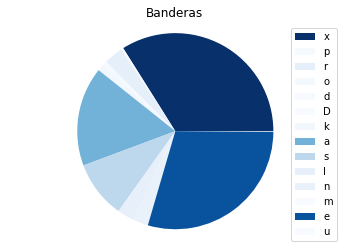

In [54]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib import colors

c = list(summary_flags.total)
f = list(summary_flags.Flags)


normdata = colors.Normalize(min(c), max(c))
colormap = cm.get_cmap("Blues")
colores =colormap(normdata(c))

image = plt.pie(c, labels=f, colors=colores, textprops=dict(color="w"))
image =plt.axis("equal")
image= plt.title("Banderas")
image = plt.legend(loc='upper right')

#images_dir = '/content/drive/Shareddrives/DatosSIMA'
#plt.savefig(f"{images_dir}/banderasp.png")


ValueError: ignored

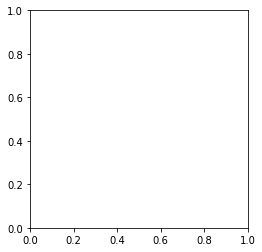

In [36]:
plt.pie(
    c,
    labels = f ,
    explode = [0.07] ,
  textprops={'fontsize': 20}
)
plt.title("Frecuencia de Defectos")

plt.savefig("Defectos.png", dpi=300, bbox_inches='tight')

In [ ]:
save_to_Drive("/content/drive/Shareddrives/DatosSIMA/",summary_flags,"banderas")

In [ ]:
save_to_Drive("/content/drive/Shareddrives/DatosSIMA/",summary_flags,"banderas")

In [ ]:
save_to_Drive("/content/drive/Shareddrives/DatosSIMA/",df_new,"baseoriginal")

In [ ]:
data_stats=data_stats.select_dtypes(include=np.number)  

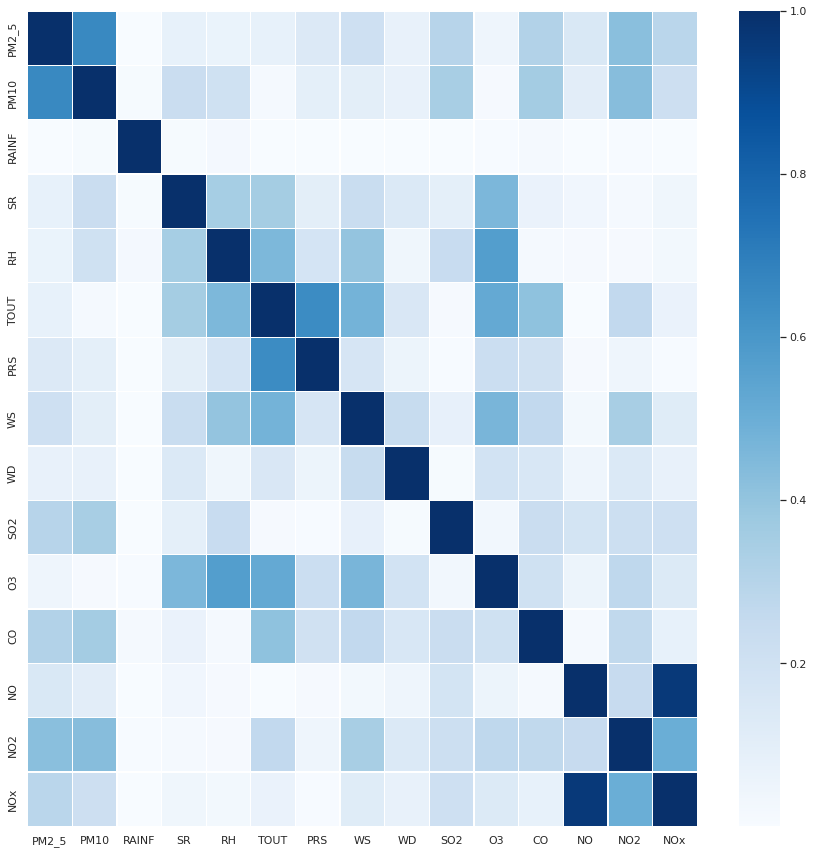

In [ ]:
import seaborn as sms
import matplotlib.pyplot as plt 
# Apply for a last time the correlatio matrix to delete correlated columns 
cor_matrix = df_new.select_dtypes(include=np.number).corr().abs()                         ## create the correlation Matrix
sms.set(rc = {'figure.figsize':(15,15)})                  ## create a heatmap with the correlation matrix
sms.heatmap(cor_matrix,cmap="Blues", xticklabels=True, yticklabels=True, linewidth=0.3)
images_dir = '/content/drive/Shareddrives/DatosSIMA'
plt.savefig(f"{images_dir}/mapacolor.png")

In [ ]:
#cor_matrix
save_to_Drive("/content/drive/Shareddrives/DatosSIMA/",cor_matrix,"correlacionO")

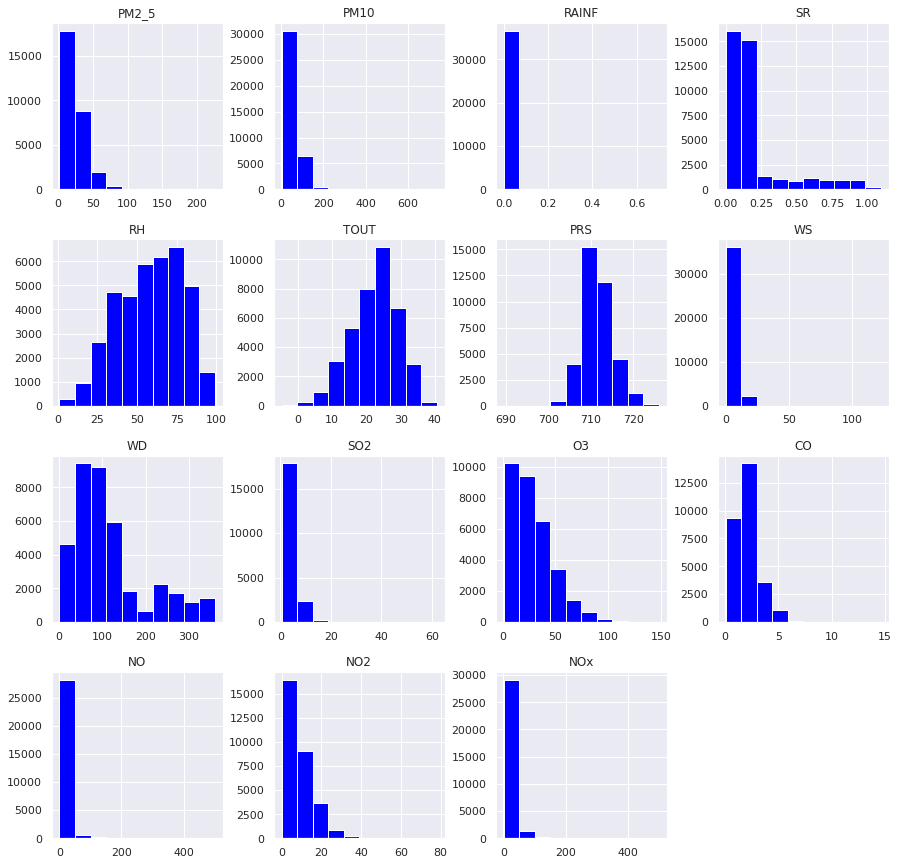

In [ ]:
#Histogramas
df_new.select_dtypes(include=np.number).hist(color="blue")
images_dir = '/content/drive/Shareddrives/DatosSIMA'
plt.savefig(f"{images_dir}/histogramas.png")